In [7]:
import sys

sys.path.append('..')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Import our custom DiD implementation
from src.causal_methods.did import DifferenceInDifferences, load_and_prepare_data

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("✅ Imports successful!")


✅ Imports successful!


In [8]:
# Load the data
df = load_and_prepare_data("../data/simulated_users.csv")

print("Dataset shape:", df.shape)
print("\nKey variables for DiD analysis:")
print("- Treatment: used_smart_assistant")
print("- Pre-treatment outcome: filed_2023")
print("- Post-treatment outcome: filed_2024")
print("- User identifier: user_id")

# Quick overview
df[['user_id', 'used_smart_assistant', 'filed_2023', 'filed_2024', 'age', 'income_bracket']].head()


Dataset shape: (10000, 20)

Key variables for DiD analysis:
- Treatment: used_smart_assistant
- Pre-treatment outcome: filed_2023
- Post-treatment outcome: filed_2024
- User identifier: user_id


,user_id,used_smart_assistant,filed_2023,filed_2024,age,income_bracket
0,user_000000,0,1,1,41,50k-75k
1,user_000001,0,0,0,37,<30k
2,user_000002,1,0,1,19,30k-50k
3,user_000003,0,0,1,66,75k-100k
4,user_000004,1,1,0,27,30k-50k


In [9]:
# Summary statistics by treatment group
print("="*60)
print("TREATMENT VS CONTROL GROUP COMPARISON")
print("="*60)

summary_stats = df.groupby('used_smart_assistant').agg({
    'filed_2023': ['count', 'mean'],
    'filed_2024': 'mean',
    'age': 'mean',
    'tech_savviness': 'mean'
}).round(3)

print("\nSummary by Treatment Status:")
print(summary_stats)

# Calculate naive treatment effect
treated_2024 = df[df['used_smart_assistant'] == 1]['filed_2024'].mean()
control_2024 = df[df['used_smart_assistant'] == 0]['filed_2024'].mean()
naive_effect = treated_2024 - control_2024

print("\n📈 NAIVE COMPARISON (2024 only):")
print(f"Treated group filing rate: {treated_2024:.1%}")
print(f"Control group filing rate: {control_2024:.1%}")
print(f"Naive treatment effect: {naive_effect:.1%}")
print("\n⚠️  This is likely BIASED due to selection effects!")


TREATMENT VS CONTROL GROUP COMPARISON

Summary by Treatment Status:
                     filed_2023        filed_2024     age tech_savviness
                          count   mean       mean    mean           mean
used_smart_assistant                                                    
0                          3858  0.828      0.878  49.734         42.400
1                          6142  0.859      0.932  41.282         59.388

📈 NAIVE COMPARISON (2024 only):
Treated group filing rate: 93.2%
Control group filing rate: 87.8%
Naive treatment effect: 5.4%

⚠️  This is likely BIASED due to selection effects!


Filing Rates by Group and Year:
                            Group  2023 (Pre-treatment)  2024 (Post-treatment)
0    Control (No Smart Assistant)                 0.828                  0.878
1  Treated (Used Smart Assistant)                 0.859                  0.932

📊 CHANGES OVER TIME:
Control group change: 0.051
Treated group change: 0.073
Difference-in-Differences: 0.022


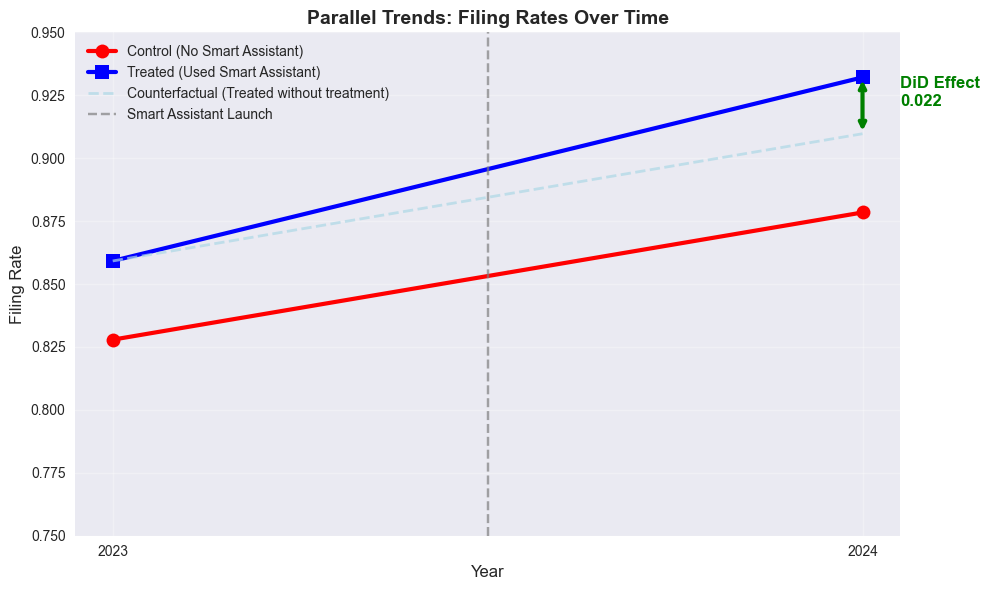

In [10]:
# Create means table for visualization
means_table = pd.DataFrame({
    'Group': ['Control (No Smart Assistant)', 'Treated (Used Smart Assistant)'],
    '2023 (Pre-treatment)': [
        df[df['used_smart_assistant'] == 0]['filed_2023'].mean(),
        df[df['used_smart_assistant'] == 1]['filed_2023'].mean()
    ],
    '2024 (Post-treatment)': [
        df[df['used_smart_assistant'] == 0]['filed_2024'].mean(),
        df[df['used_smart_assistant'] == 1]['filed_2024'].mean()
    ]
})

print("Filing Rates by Group and Year:")
print(means_table.round(3))

# Calculate the changes
control_change = means_table.loc[0, '2024 (Post-treatment)'] - means_table.loc[0, '2023 (Pre-treatment)']
treated_change = means_table.loc[1, '2024 (Post-treatment)'] - means_table.loc[1, '2023 (Pre-treatment)']

print("\n📊 CHANGES OVER TIME:")
print(f"Control group change: {control_change:.3f}")
print(f"Treated group change: {treated_change:.3f}")
print(f"Difference-in-Differences: {treated_change - control_change:.3f}")

# Visualize parallel trends
fig, ax = plt.subplots(figsize=(10, 6))

years = [2023, 2024]
control_means = [means_table.loc[0, '2023 (Pre-treatment)'], means_table.loc[0, '2024 (Post-treatment)']]
treated_means = [means_table.loc[1, '2023 (Pre-treatment)'], means_table.loc[1, '2024 (Post-treatment)']]

ax.plot(years, control_means, 'o-', linewidth=3, markersize=10,
        label='Control (No Smart Assistant)', color='red')
ax.plot(years, treated_means, 's-', linewidth=3, markersize=10,
        label='Treated (Used Smart Assistant)', color='blue')

# Add counterfactual line (what treated would have been without treatment)
counterfactual_2024 = means_table.loc[1, '2023 (Pre-treatment)'] + control_change
ax.plot([2023, 2024], [means_table.loc[1, '2023 (Pre-treatment)'], counterfactual_2024],
        '--', linewidth=2, color='lightblue', alpha=0.7, label='Counterfactual (Treated without treatment)')

# Add treatment effect arrow
ax.annotate('', xy=(2024, means_table.loc[1, '2024 (Post-treatment)']),
            xytext=(2024, counterfactual_2024),
            arrowprops=dict(arrowstyle='<->', color='green', lw=3))
ax.text(2024.05, (means_table.loc[1, '2024 (Post-treatment)'] + counterfactual_2024)/2,
        f'DiD Effect\n{treated_change - control_change:.3f}',
        fontsize=12, color='green', weight='bold')

# Formatting
ax.axvline(x=2023.5, color='gray', linestyle='--', alpha=0.7, label='Smart Assistant Launch')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Filing Rate', fontsize=12)
ax.set_title('Parallel Trends: Filing Rates Over Time', fontsize=14, weight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(years)
ax.set_ylim(0.75, 0.95)

plt.tight_layout()
plt.show()


In [11]:
# Initialize DiD estimator
did_estimator = DifferenceInDifferences(df)

# Prepare panel data (reshape from wide to long)
panel_data = did_estimator.prepare_panel_data()

print("Panel data structure:")
print(f"Original data: {len(df)} users")
print(f"Panel data: {len(panel_data)} observations ({len(panel_data)//2} users × 2 time periods)")

# Show structure of panel data
print("\nPanel data sample:")
panel_data.head(10)


Panel data structure:
Original data: 10000 users
Panel data: 20000 observations (10000 users × 2 time periods)

Panel data sample:


,user_id,year,post_treatment,treated,outcome,treatment_x_post,age,income_bracket,device_type,user_type,region,tech_savviness
0,user_000000,2023,0,0,1,0,41,50k-75k,tablet,returning,Midwest,41
1,user_000000,2024,1,0,1,0,41,50k-75k,tablet,returning,Midwest,41
2,user_000001,2023,0,0,0,0,37,<30k,desktop,returning,Midwest,43
3,user_000001,2024,1,0,0,0,37,<30k,desktop,returning,Midwest,43
4,user_000002,2023,0,1,0,0,19,30k-50k,mobile,new,East,61
5,user_000002,2024,1,1,1,1,19,30k-50k,mobile,new,East,61
6,user_000003,2023,0,0,0,0,66,75k-100k,mobile,new,East,31
7,user_000003,2024,1,0,1,0,66,75k-100k,mobile,new,East,31
8,user_000004,2023,0,1,1,0,27,30k-50k,desktop,returning,West,85
9,user_000004,2024,1,1,0,1,27,30k-50k,desktop,returning,West,85


In [12]:
# Estimate DiD effect (basic model)
print("🔧 BASIC DiD MODEL")
print("="*50)

basic_results = did_estimator.estimate_did()

# Display results
print(f"DiD Treatment Effect: {basic_results['did_estimate']:.4f}")
print(f"Standard Error: {basic_results['standard_error']:.4f}")
print(f"P-value: {basic_results['p_value']:.4f}")
print(f"95% Confidence Interval: [{basic_results['conf_int_lower']:.4f}, {basic_results['conf_int_upper']:.4f}]")

# Show the full regression output
print("\n📊 FULL REGRESSION RESULTS:")
print(basic_results['model'].summary())


🔧 BASIC DiD MODEL
DiD Treatment Effect: 0.0224
Standard Error: 0.0089
P-value: 0.0114
95% Confidence Interval: [0.0050, 0.0398]

📊 FULL REGRESSION RESULTS:
                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     115.7
Date:                Sun, 20 Jul 2025   Prob (F-statistic):           1.27e-73
Time:                        22:34:09   Log-Likelihood:                -5810.2
No. Observations:               20000   AIC:                         1.163e+04
Df Residuals:                   19996   BIC:                         1.166e+04
Df Model:                           3                                         
Covariance Type:              cluster                                         
                       coef    std err          z     

In [13]:
# Estimate DiD with control variables
print("🔧 DiD MODEL WITH CONTROLS")
print("="*50)

control_vars = ['age', 'tech_savviness']
controlled_results = did_estimator.estimate_did(control_vars=control_vars)

print(f"DiD Treatment Effect (with controls): {controlled_results['did_estimate']:.4f}")
print(f"Standard Error: {controlled_results['standard_error']:.4f}")
print(f"P-value: {controlled_results['p_value']:.4f}")
print(f"95% Confidence Interval: [{controlled_results['conf_int_lower']:.4f}, {controlled_results['conf_int_upper']:.4f}]")

# Compare with basic model
print("\n📈 COMPARISON:")
print(f"Basic DiD estimate: {basic_results['did_estimate']:.4f}")
print(f"Controlled DiD estimate: {controlled_results['did_estimate']:.4f}")
print(f"Difference: {controlled_results['did_estimate'] - basic_results['did_estimate']:.4f}")

# Update main results to the controlled version
did_estimator.results['main'] = controlled_results


🔧 DiD MODEL WITH CONTROLS
DiD Treatment Effect (with controls): 0.0224
Standard Error: 0.0089
P-value: 0.0114
95% Confidence Interval: [0.0050, 0.0398]

📈 COMPARISON:
Basic DiD estimate: 0.0224
Controlled DiD estimate: 0.0224
Difference: 0.0000


In [14]:
# Test parallel trends assumption
parallel_trends_results = did_estimator.parallel_trends_test()

print("🔍 PARALLEL TRENDS TESTS")
print("="*50)
print(f"Test type: {parallel_trends_results['test_type']}")
print(f"Description: {parallel_trends_results['description']}")
print(f"Interpretation: {parallel_trends_results['interpretation']}")

print("\nCorrelations between treatment and pre-treatment outcomes:")
for outcome, result in parallel_trends_results['results'].items():
    significance = "***" if result['significant'] else ""
    print(f"  {outcome}: {result['correlation']:.3f} (p={result['p_value']:.3f}) {significance}")

print("\n⚠️  High correlations suggest potential parallel trends violations")
print("✅  Low correlations support the parallel trends assumption")


Note: With only 2 time periods (2023, 2024), formal parallel trends testing is limited.
In practice, you would need multiple pre-treatment periods.
🔍 PARALLEL TRENDS TESTS
Test type: baseline_correlation
Description: Correlation between treatment and pre-treatment outcomes
Interpretation: High correlations suggest potential parallel trends violations

Correlations between treatment and pre-treatment outcomes:
  filed_2023: 0.042 (p=0.000) ***
  time_to_complete_2023: -0.186 (p=0.000) ***
  sessions_2023: -0.057 (p=0.000) ***
  support_tickets_2023: -0.013 (p=0.188) 

⚠️  High correlations suggest potential parallel trends violations
✅  Low correlations support the parallel trends assumption


🎯 HETEROGENEOUS EFFECTS BY AGE GROUP
35-50: 0.0175 (0.0142) 
  95% CI: [-0.0103, 0.0453]
  N users: 3772

<35: 0.0399 (0.0233) 
  95% CI: [-0.0058, 0.0857]
  N users: 2797

65+: 0.0401 (0.0385) 
  95% CI: [-0.0354, 0.1155]
  N users: 783

50-65: 0.0204 (0.0179) 
  95% CI: [-0.0147, 0.0555]
  N users: 2648



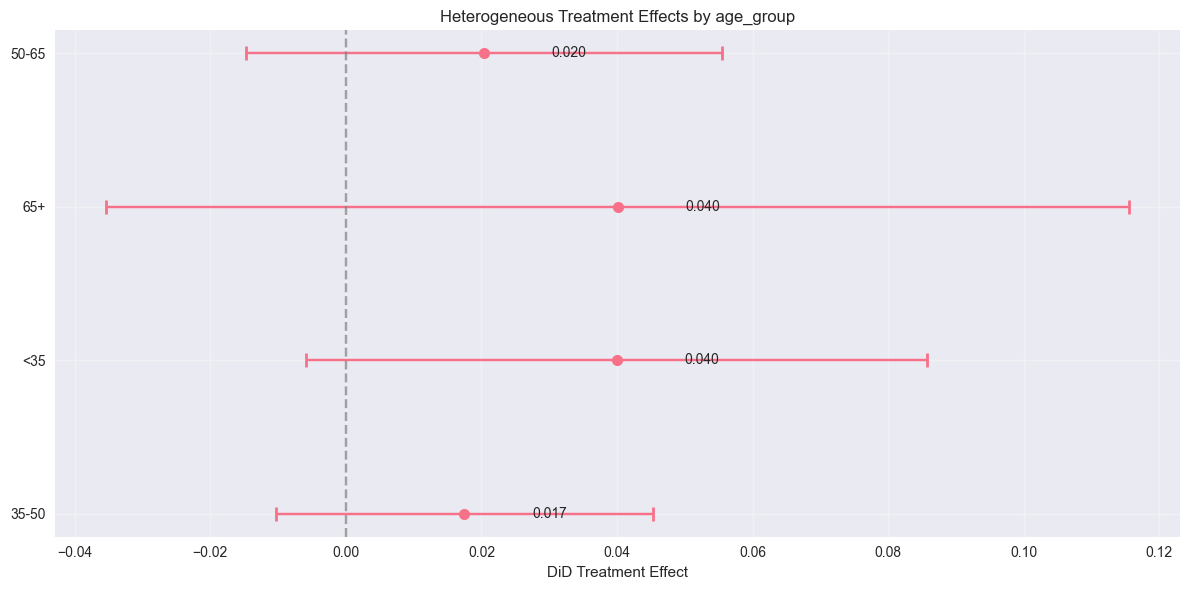

In [15]:
# Estimate effects by age group
age_effects = did_estimator.estimate_heterogeneous_effects('age_group')

print("🎯 HETEROGENEOUS EFFECTS BY AGE GROUP")
print("="*50)

for age_group, results in age_effects['results'].items():
    significance = "***" if results['p_value'] < 0.001 else ("**" if results['p_value'] < 0.01 else ("*" if results['p_value'] < 0.05 else ""))
    print(f"{age_group}: {results['did_estimate']:.4f} ({results['standard_error']:.4f}) {significance}")
    print(f"  95% CI: [{results['conf_int_lower']:.4f}, {results['conf_int_upper']:.4f}]")
    print(f"  N users: {results['n_users']}")
    print()

# Plot heterogeneous effects
fig = did_estimator.plot_subgroup_effects(age_effects, figsize=(12, 6))
plt.show()


🎯 HETEROGENEOUS EFFECTS BY INCOME BRACKET
50k-75k: 0.0288 (0.0184) 
  95% CI: [-0.0072, 0.0648]

<30k: 0.1069 (0.0320) ***
  95% CI: [0.0442, 0.1696]

30k-50k: 0.0603 (0.0210) **
  95% CI: [0.0192, 0.1014]

75k-100k: -0.0274 (0.0159) 
  95% CI: [-0.0586, 0.0037]

100k-150k: -0.0047 (0.0223) 
  95% CI: [-0.0484, 0.0390]

>150k: 0.0108 (0.0384) 
  95% CI: [-0.0646, 0.0861]



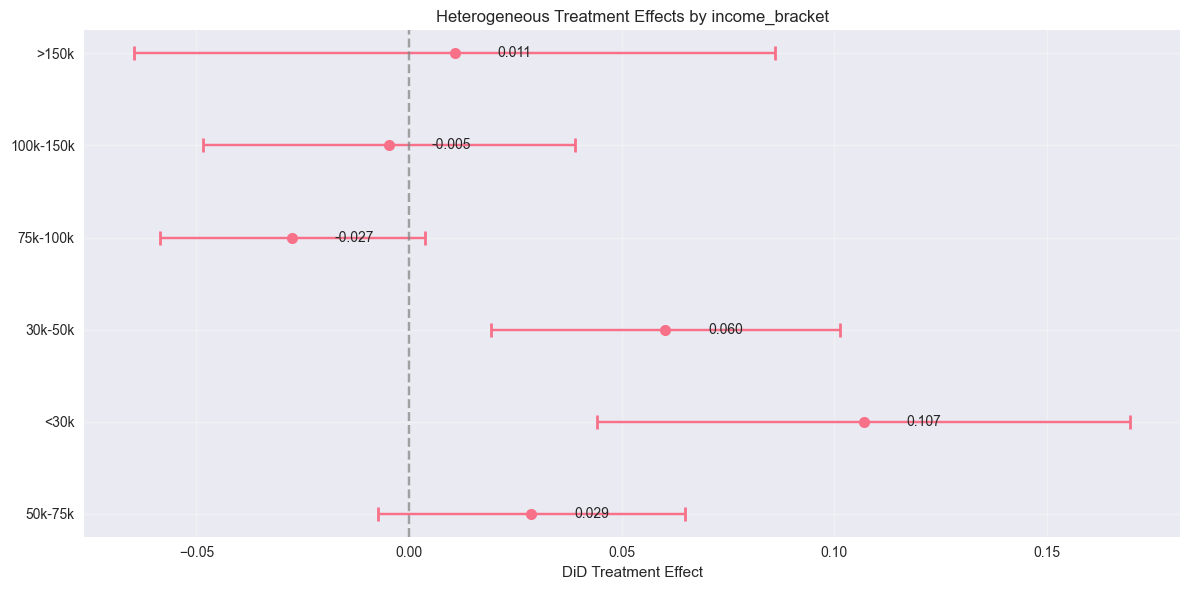

In [16]:
# Effects by income bracket
income_effects = did_estimator.estimate_heterogeneous_effects('income_bracket')

print("🎯 HETEROGENEOUS EFFECTS BY INCOME BRACKET")
print("="*50)

for income_bracket, results in income_effects['results'].items():
    significance = "***" if results['p_value'] < 0.001 else ("**" if results['p_value'] < 0.01 else ("*" if results['p_value'] < 0.05 else ""))
    print(f"{income_bracket}: {results['did_estimate']:.4f} ({results['standard_error']:.4f}) {significance}")
    print(f"  95% CI: [{results['conf_int_lower']:.4f}, {results['conf_int_upper']:.4f}]")
    print()

# Plot income effects
fig = did_estimator.plot_subgroup_effects(income_effects, figsize=(12, 6))
plt.show()


🎯 HETEROGENEOUS EFFECTS BY USER TYPE
returning: 0.0138 (0.0109) 
  95% CI: [-0.0076, 0.0352]

new: 0.0455 (0.0175) **
  95% CI: [0.0113, 0.0797]



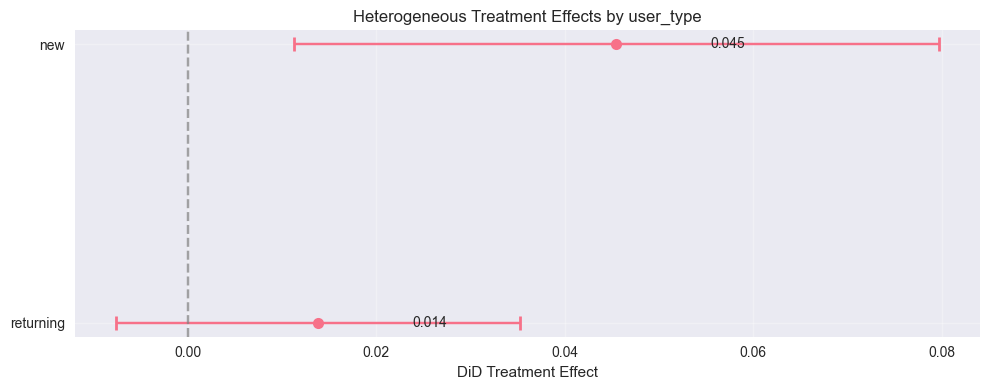

In [17]:
# Effects by user type (new vs returning)
user_type_effects = did_estimator.estimate_heterogeneous_effects('user_type')

print("🎯 HETEROGENEOUS EFFECTS BY USER TYPE")
print("="*50)

for user_type, results in user_type_effects['results'].items():
    significance = "***" if results['p_value'] < 0.001 else ("**" if results['p_value'] < 0.01 else ("*" if results['p_value'] < 0.05 else ""))
    print(f"{user_type}: {results['did_estimate']:.4f} ({results['standard_error']:.4f}) {significance}")
    print(f"  95% CI: [{results['conf_int_lower']:.4f}, {results['conf_int_upper']:.4f}]")
    print()

# Plot user type effects
fig = did_estimator.plot_subgroup_effects(user_type_effects, figsize=(10, 4))
plt.show()


In [18]:
# Generate comprehensive summary
summary = did_estimator.summary_report()
print(summary)


DIFFERENCE-IN-DIFFERENCES ANALYSIS SUMMARY

Treatment Effect Estimate: 0.0224
Standard Error: 0.0089
P-value: 0.0114
95% Confidence Interval: [0.0050, 0.0398]

Statistical Significance: significant (p < 0.05)

Sample Size: 10,000 users, 20,000 observations

INTERPRETATION:
----------------------------------------
The Smart Filing Assistant increased the filing rate by 2.2 percentage points on average.

This effect is statistically significant, suggesting the Smart Filing Assistant has a genuine causal impact on user conversion rates.

